In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyarrow import parquet
from scipy.stats import zscore

In [72]:
# Load datasets
df = pd.read_parquet('/kaggle/input/merged-new/joined_1day_no.parquet')

In [73]:
df = df[df['Name']!='Senja-Grasmyrskogen']
df.loc[df['T_air_night'] > 30, 'T_air_night'] = np.nan
df['Date'] = pd.to_datetime(df['Date'])
df = df[df['Date'].dt.year > 2011]

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


In [74]:
# Compute difference
df['day_diff'] = df['LST_Day_1km'] - df['T_air_day']
df['night_diff'] = df['LST_Night_1km'] - df['T_air_night']

In [68]:
# Fraction of extreme values
day_n = df['day_diff'].notna().sum()
day_fh = df['day_diff'].gt(10).sum() / day_n
day_fl = df['day_diff'].lt(-10).sum() / day_n
night_n = df['night_diff'].notna().sum()
night_fh = df['night_diff'].gt(10).sum() / night_n
night_fl = df['night_diff'].lt(-10).sum() / night_n
print(f'day non_nan count: {day_n}\nnight non_nan count: {night_n}\nday high extreme fraction: {day_fh}\nday low extreme fraction: {day_fl}\nnight high extreme fraction: {night_fh}\nnight low extreme fraction: {night_fl}')

day non_nan count: 264092
night non_nan count: 273660
day high extreme fraction: 0.0023703860775790256
day low extreme fraction: 0.1180687033306575
night high extreme fraction: 0.001132792516261054
night low extreme fraction: 0.17542936490535702


/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


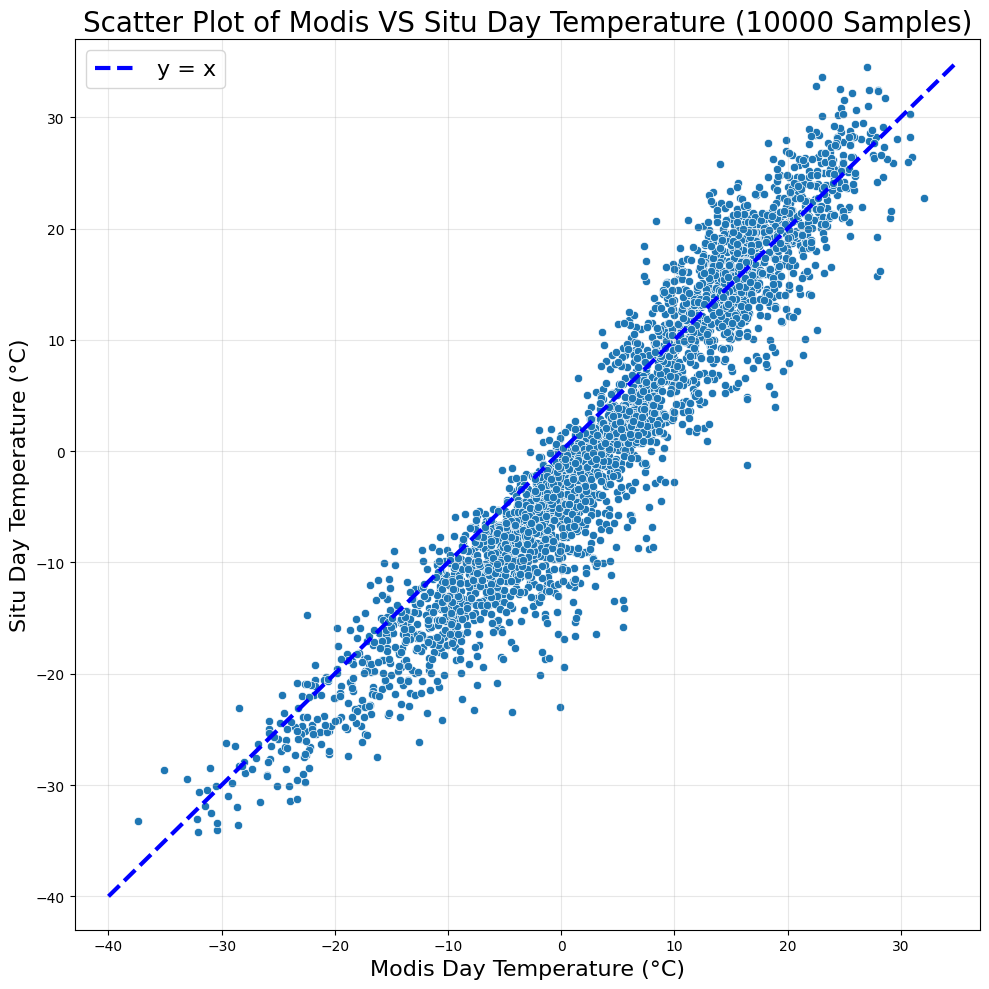

In [50]:
# Create the scatter plot of Modis vs Situ
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df.sample(10000), x='T_air_day', y='LST_Day_1km')

# Add a y=x line
x_values = np.linspace(-40, 35, 100)
plt.plot(x_values, x_values, color='blue', linestyle='--', linewidth=3, label='y = x')
plt.xlabel('Modis Day Temperature (°C)', fontsize=16)
plt.ylabel('Situ Day Temperature (°C)', fontsize=16)
plt.xlim(-43, 37)
plt.ylim(-43, 37)
plt.title('Scatter Plot of Modis VS Situ Day Temperature (10000 Samples)', fontsize=20)
plt.legend(fontsize=16)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('modisvssitu1.png')
plt.show()

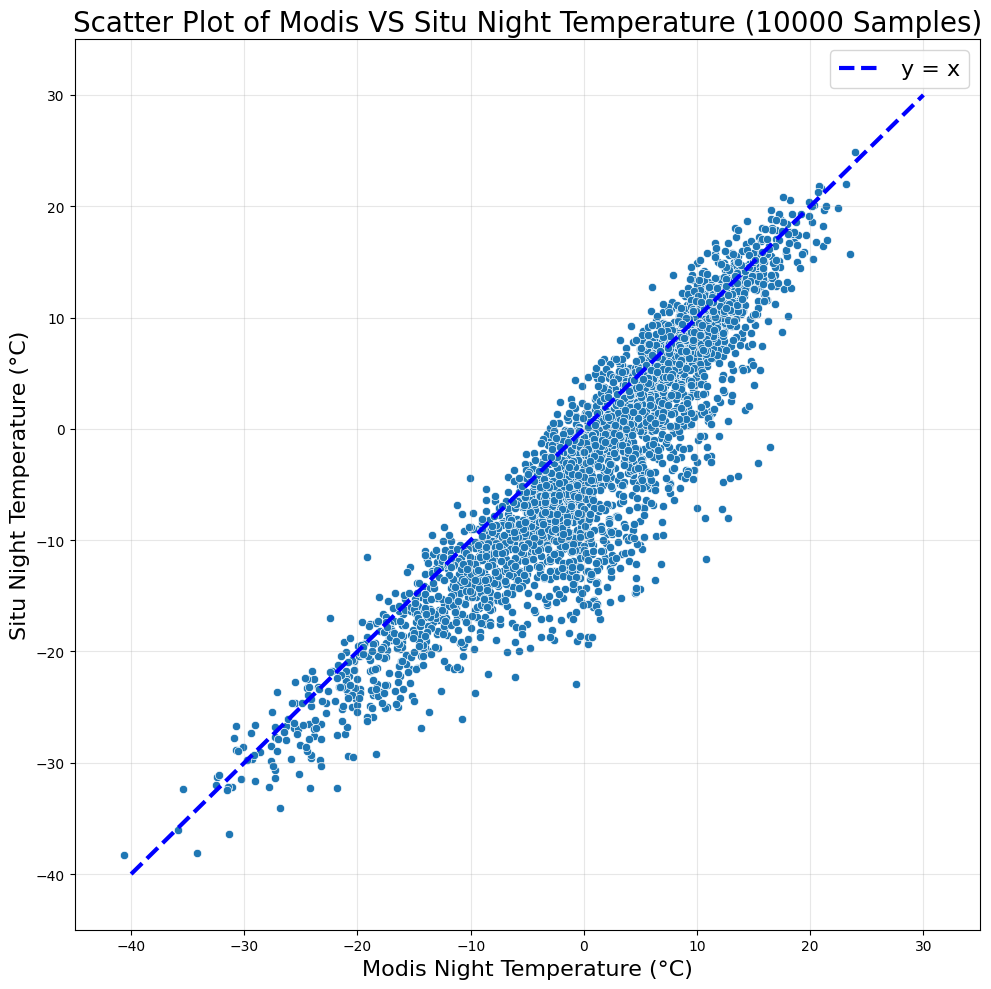

In [52]:
# Create the scatter plot of Modis vs Situ
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df.sample(10000), x='T_air_night', y='LST_Night_1km')

# Add a y=x line
x_values = np.linspace(-40, 30, 100)
plt.plot(x_values, x_values, color='blue', linestyle='--', linewidth=3, label='y = x')
plt.xlabel('Modis Night Temperature (°C)', fontsize=16)
plt.ylabel('Situ Night Temperature (°C)', fontsize=16)
plt.xlim(-45, 35)
plt.ylim(-45, 35)
plt.title('Scatter Plot of Modis VS Situ Night Temperature (10000 Samples)', fontsize=20)
plt.legend(fontsize=16)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('modisvssitu2.png')
plt.show()

In [75]:
# QC mapping
custom_dict = {
    0: {'1': 0, '2': 0, '3': 0},
    2: {'1': 0, '2': 1, '3': 0},
    3: {'1': 0, '2': 0, '3': 1},
    5: {'1': 0, '2': 0, '3': 0},
    8: {'1': 0, '2': 1, '3': 0},
    17: {'1': 1, '2': 0, '3': 0},
    25: {'1': 1, '2': 1, '3': 0},
    65: {'1': 0, '2': 1, '3': 0},
    73: {'1': 0, '2': 1, '3': 0},
    81: {'1': 1, '2': 1, '3': 0},
    89: {'1': 1, '2': 1, '3': 0},
    129: {'1': 0, '2': 1, '3': 0},
    137: {'1': 0, '2': 1, '3': 0},
    145: {'1': 1, '2': 1, '3': 0},
    197: {'1': 0, '2': 1, '3': 0}
}

In [76]:
# Encode the QC
processed_dfs = []

for col in ['QC_Day','QC_Night']:
    # Apply mapping and add column prefix
    custom_encoded = df[col].map(lambda x: custom_dict.get(x, {'1': 0, '2': 0, '3': 0}))
    encoded = pd.DataFrame(custom_encoded.tolist(), index=df.index)
    encoded = encoded.add_prefix(f"{col}_")  # Add column-specific prefix
    processed_dfs.append(encoded)

encoded = pd.concat(processed_dfs, axis=1)

In [77]:
df1 = pd.concat([df, encoded], axis=1)

In [133]:
# Identify rows where column x > 1
rows_to_consider = df2[(df2['QC_Day_1'] == 0)&(df2['day_diff']>5)].index

# Randomly select half of these rows to drop
num_to_drop = len(rows_to_consider) // 5
rows_to_drop = np.random.choice(rows_to_consider, num_to_drop, replace=False)

# Drop the selected rows
df3 = df2.drop(index=rows_to_drop)

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


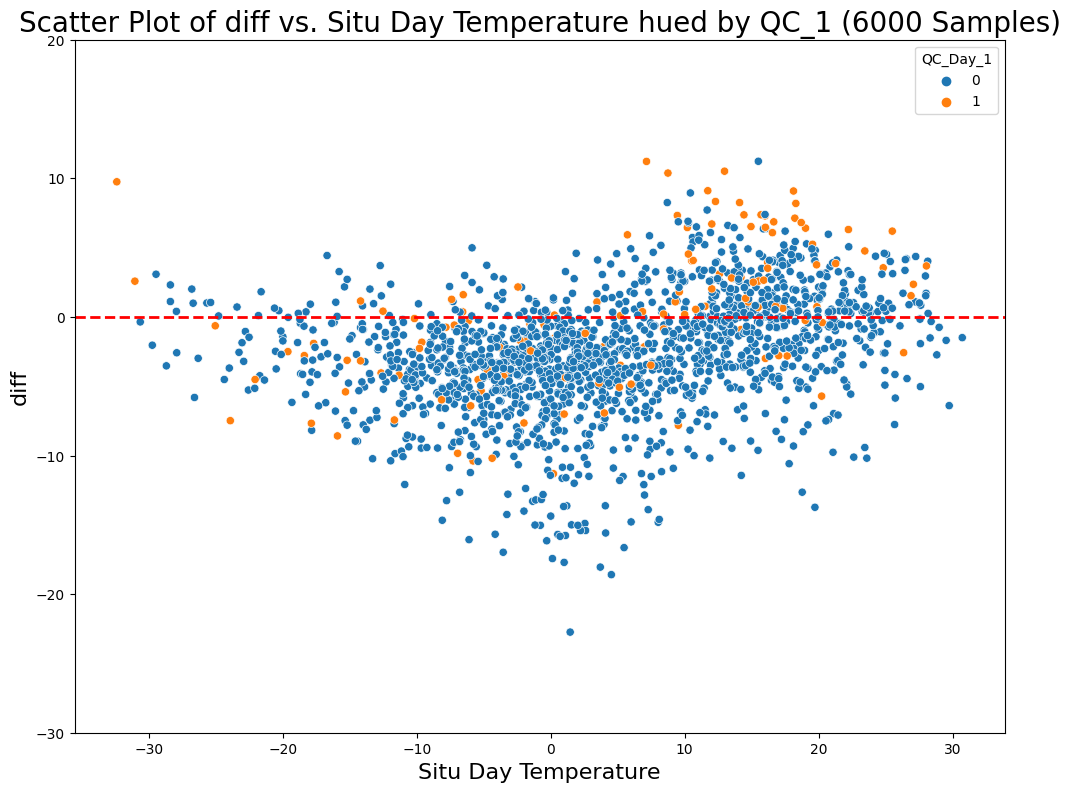

In [135]:
# Plot diff vs. Situ (Day)
plt.figure(figsize=(12, 9))
sns.scatterplot(data=df3.sample(6000), x='T_air_day', y='day_diff',hue='QC_Day_1')
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Situ Day Temperature',fontsize=16)
plt.ylabel('diff',fontsize=16)
plt.ylim(-30,20)
plt.title('Scatter Plot of diff vs. Situ Day Temperature hued by QC_1 (6000 Samples)',fontsize=20)
plt.savefig('diffvssitu1.png')
plt.show()